In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-10-17 22:00:02--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.1’

housing.csv.1       100%[===================>]   1.36M  2.59MB/s    in 0.5s    

2022-10-17 22:00:03 (2.59 MB/s) - ‘housing.csv.1’ saved [1423529/1423529]



In [44]:
import pandas as pd
import numpy as np

In [45]:
df = pd.read_csv("housing.csv")

In [46]:
df.head().T

,0,1,2,3,4
longitude,-122.23,-122.22,-122.24,-122.25,-122.25
latitude,37.88,37.86,37.85,37.85,37.85
housing_median_age,41.0,21.0,52.0,52.0,52.0
total_rooms,880.0,7099.0,1467.0,1274.0,1627.0
total_bedrooms,129.0,1106.0,190.0,235.0,280.0
population,322.0,2401.0,496.0,558.0,565.0
households,126.0,1138.0,177.0,219.0,259.0
median_income,8.3252,8.3014,7.2574,5.6431,3.8462
median_house_value,452600.0,358500.0,352100.0,341300.0,342200.0
ocean_proximity,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY


In [47]:
cols = [
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value',
    'ocean_proximity'
]

In [48]:
df = df[cols]

In [49]:
df = df.fillna(0)

In [50]:
from matplotlib import pyplot as plt

In [51]:
df['median_house_value'] = np.log1p(df['median_house_value'])

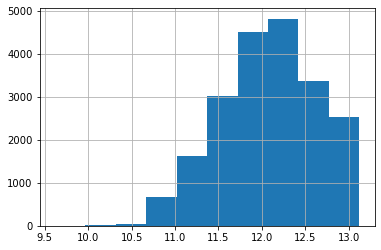

In [52]:
df['median_house_value'].hist()
plt.show()

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [55]:
y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values
y_test = df_test['median_house_value'].values

In [56]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [57]:
from sklearn.feature_extraction import DictVectorizer

In [58]:
train_dicts = df_train.to_dict(orient='records')

In [59]:
dv = DictVectorizer(sparse=False)

In [60]:
X_train = dv.fit_transform(train_dicts)

In [61]:
train_dicts

[{'latitude': 34.63,
  'longitude': -118.18,
  'housing_median_age': 19.0,
  'total_rooms': 3562.0,
  'total_bedrooms': 606.0,
  'population': 1677.0,
  'households': 578.0,
  'median_income': 4.1573,
  'ocean_proximity': 'INLAND'},
 {'latitude': 34.69,
  'longitude': -116.9,
  'housing_median_age': 10.0,
  'total_rooms': 337.0,
  'total_bedrooms': 102.0,
  'population': 108.0,
  'households': 50.0,
  'median_income': 0.4999,
  'ocean_proximity': 'INLAND'},
 {'latitude': 33.78,
  'longitude': -118.26,
  'housing_median_age': 27.0,
  'total_rooms': 1672.0,
  'total_bedrooms': 491.0,
  'population': 1723.0,
  'households': 462.0,
  'median_income': 2.0458,
  'ocean_proximity': 'NEAR OCEAN'},
 {'latitude': 34.17,
  'longitude': -117.33,
  'housing_median_age': 5.0,
  'total_rooms': 4718.0,
  'total_bedrooms': 1140.0,
  'population': 2564.0,
  'households': 1056.0,
  'median_income': 2.9877,
  'ocean_proximity': 'INLAND'},
 {'latitude': 35.35,
  'longitude': -119.02,
  'housing_median_age'

In [66]:
from sklearn.tree import DecisionTreeRegressor

In [67]:
dt = DecisionTreeRegressor(max_depth=1)

In [68]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [71]:
X_val = dv.transform(df_val.to_dict(orient='records'))

In [72]:
y_pred = dt.predict(X_val)

In [75]:
from sklearn.tree import export_text
export_text(dt, feature_names=dv.get_feature_names())

/home/wo/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


'|--- ocean_proximity=INLAND <= 0.50\n|   |--- value: [12.31]\n|--- ocean_proximity=INLAND >  0.50\n|   |--- value: [11.61]\n'

In [78]:
from sklearn.ensemble import RandomForestRegressor

In [79]:
rf = RandomForestRegressor(n_estimators=10,
                            random_state=1,
                            n_jobs=-1)

In [80]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [83]:
y_pred = rf.predict(X_val)

In [84]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [88]:
rmse(y_val, y_pred)

0.2456601287532493

In [90]:
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n,
                                # max_depth=1,
                                random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    print((n, rmse(y_val, y_pred)))

(10, 0.24566012875324933)
(20, 0.238831005084315)
(30, 0.23533513359926886)
(40, 0.23425705015789774)
(50, 0.23299051006423965)
(60, 0.23276663500988132)
(70, 0.23233674302516488)
(80, 0.2324032922144551)
(90, 0.23210724563250076)
(100, 0.23192762024978078)
(110, 0.2314750864065383)
(120, 0.23152853340217378)
(130, 0.23163264491363297)
(140, 0.23160551396177223)
(150, 0.23160365347894832)
(160, 0.23154043638797991)
(170, 0.23143152802305048)
(180, 0.23163349793869303)
(190, 0.23162048688517478)
(200, 0.23151712261805216)


In [96]:
for m in [10, 15, 20, 25]:
    rf = RandomForestRegressor(n_estimators=100,
                               max_depth=m,
                               random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    print((m, rmse(y_val, y_pred)))

(10, 0.2491402497670221)
(15, 0.23374832557181263)
(20, 0.23221138969987742)
(25, 0.23159645174563892)
